# 한국어 추출 요약 모델 

In [12]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request 
np.random.seed(seed=0)

## 1. Data

In [2]:
df = pd.read_excel("종합 텍스트.xlsx")

In [3]:
df.shape

(16983, 18)

In [4]:
df.columns

Index(['기사번호', '기사카테고리', '매체유형', '매체구분', '매체명', '기사대중소', '기사본문글자수', '발행일시',
       '제목', '내용', '가독성', '정확성', '정보성', '신뢰성', '생성', '추출1', '추출2', '추출3'],
      dtype='object')

In [5]:
df1 = df['추출1']
df2 = df['추출2']
df3 = df['추출3']
print(df1[0])
print(df2[0])
print(df3[0])
print(df1[1])
print(df1[2])
print(df3[1])

검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.
형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다.
이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견제를 통해 국민의 인권을 증진하자는 것이다.
임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 교수)이 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 ‘소나무허리노린재<사진>’가 인천지역 공원과 산림에서 확인했다.
건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 따른 심평원 설립 취지를 훼손시키고 있다는 지적이 대두됐다.
국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산에 심각한 피해가 예상된다.


In [6]:
news = df1+df2+df3
news

0        검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.형사 사법제도의 본질은 경...
1        임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 ...
2        건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 ...
3        부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램...
4        가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 ...
                               ...                        
16978    TK 한국당은 현재 대구 3곳에 당협위원장이 공석상태로 조직정비에 적지 않은 차질을...
16979    현대건설이 달성군 다사읍에 ‘힐스테이트 다사역’ 모델하우스를 31일 오픈하고 본격 ...
16980    비수도권 최대 규모의 보건·의료산업 전시회인 ‘2019 메디엑스포 코리아’가 대구엑...
16981    청년들이 찾는 이웃사촌시범마을의 성공적인 정착을 위해 의성군이 청년창업가와의 소통을...
16982    요즘 가장 핫한 곳으로 일컬어지는 동대구역에 포스코 더샵이 들어선다는 소식으로 수요...
Length: 16983, dtype: object

In [7]:
print(type(news))
print(news.shape)

<class 'pandas.core.series.Series'>
(16983,)


## 엑셀 열 이어붙여서 추출과 생성만 추려내기 

In [15]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

C:\Users\USER\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [16]:
df_news=pd.concat([news,df['생성']],axis=1)

In [17]:
df_news.columns = ['추출', "생성"]
df_news

,추출,생성
0,검경 수사권 개혁에 대한 문제는 현 정부의 핵심 과제이다.형사 사법제도의 본질은 경찰·검찰·법원 등 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다.이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 타 기관과의 상호 감시와 견제를 통해 국민의 인권을 증진하자는 것이다.,현 정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력의 견제와 균형을 이루어 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다.
1,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단(단장 배양섭 인천대 교수)이 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 ‘소나무허리노린재<사진>’가 인천지역 공원과 산림에서 확인했다.15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는 월미도와 인천대학교 송도캠퍼스 등에서 정착한 개체군을 확인했다.국내에서 발생이 확대될 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산에 심각한 피해가 예상된다.,임업진흥원 외래 무척추동물의 확산 및 변화예측 기술개발 사업단'이 월미도와 인천대학교 송도캠퍼스 등에서 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 '소나무허리노린재'의 개체군이 정착한 것을 확인했으며 국내에서 발생이 늘어날 경우 침엽수 비중이 높은 산림생태계 및 가평 등지의 잣 생산에 심각한 피해가 우려된다.
2,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 따른 심평원 설립 취지를 훼손시키고 있다는 지적이 대두됐다.더불어민주당 김상희(부천 소사) 국회원이 건강보험공단에서 확인한 자료에 따르면 심평원은 2015년 이전부터 수사기관에서 의뢰가 들어오면 간간히 지원업무를 해오다 2015년 1월부터 전담부서인 공공심사부를 설치했으며 2016년 ‘보험사기방지 특별법’이 제정되면서 법에 따라 공식적으로 입원적정성 심사 업무를 수행해 왔다.문제는 이 돈이 건강보험 재정에서 나온다는 것이다.,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험사기 방지’ 업무를 수행해 온 심평원이 건강보험 재정으로 민간보험사의 이익을 활성화하는 역할을 수행하고 있다고 비판했다.
3,"부천시는 어린이들이 우리 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 운영한다고 26일 밝혔다.가족 체험에 참여하면 포도 수확, 포도 맛보기 체험을 하고 수확한 포도(5㎏)를 가져갈 수 있다.시 관계자는 ""도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소중한 추억이 될 것""이라며 ""시민들이 우리 지역의 농업과 농촌을 이해하고 농산물을 믿고 구입하는 기회가 되길 바란다""고 말했다.",부천시는 포도를 수확하고 맛도 볼 수 있으며 수확한 포도(5kg)을 가져갈 수 있는 포도 수확 체험 프로그램을 운영하여 시민들에게 추억을 남기고 농산물에 대한 신뢰를 높이는 기회로 삼고 있다.
4,"가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 문화소풍’을 올해 마지막으로 추진했다.23일 가평읍에 따르면 ‘힐링 문화소풍!’은 복지사각지대에 있는 지역 어르신들을 대상으로 연 6회 진행되는 사업으로, 협의체 위원과 짝꿍이 되어 영화관람 후 협력업체인 파주닭국수 가평점에서 같이 식사를 하고 협의체위원들이 짝꿍(어르신)을 모시는 특화사업이다.내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다""라고 말했다.","가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께하는 힐링 문화소풍’을 진행했고, 내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 시간을 가질 계획이라고 말했다."
...,...,...
16978,TK 한국당은 현재 대구 3곳에 당협위원장이 공석상태로 조직정비에 적지 않은 차질을 빚고 있다.더불어민주당 홍의락 의원 지역구인 북을도 당협위원장이 공석이라 구심점이 없어 혼란만 가중시키고 있다.한편 내년 21대 총선에서 TK 25개 선거구(대구12·경북13)는 큰 변화 없이 선거를 치를 가능성이 점점 커지고 있다.,TK 한국당은 현재 대구 3곳에 당협위원장이 공석상태로 조직정비에 적지 않은 차질을 빚고있고 구심점없이 혼란만 가중시키고 있으며 내년 총선에서 큰 변화없이 25개 선거구로 선거를 치를 가능성이 커지고 있다
16979,현대건설이 달성군 다사읍에 ‘힐스테이트 다사역’ 모델하우스를 31일 오픈하고 본격 분양에 들어간다.이 단지가 들어설 곳은 대구지하철 2호선 다사역 초역세권 입지다.모델하우스는 대구 달서구 이곡동 성서이마트 인근에 위치할 예정이다.,31일부터 현대건설은 초역세권 입지 중 하나인 대구지하철 2호선 다사역 (달성군 다사읍)에 '힐스테이트 다사역' 모델하우스를 오픈 및 분양할 예정이다.
16980,"비수도권 최대 규모의 보건·의료산업 전시회인 ‘2019 메디엑스포 코리아’가 대구엑스코·대구의료관광진흥원·한국한의약진흥원·대구시치과의사회가 공동 주관으로 오는 21일부터 23일까지 대구엑스코에서 열린다.18일 대구시에 따르면 의료기기, 병원, 치과, 한방, 제약 등 보건의료 전 분야를 총망라한 350개사 750부스 규모로 대구엑스코 전관에서 열리며 보건의료단체들의 학술대회, 세미나, 컨퍼런스, 보수교육 등 다양한 부대행사도 동시에 펼쳐진다.특히 올해는 대구시 자매도시인 중국 닝보(寧波)시를 포함한 6개 외국 업체가 참가하며 중국 최대 온라인 쇼핑몰인 알리바바를 비롯한 25개국 230여명의 바이어들이 참가하는 역대 최대 규모의 의료마케팅 상담회가 열릴 예정이다.",대구시에 따르면 비수도권 최대규모 의료관련 전시회인 '2019 메디엑스포 코리아'가 대구엑스코에서 열리며 다양한 부대행사가 동시에 펼쳐진다고 밝히며 의료마케팅 상담회가 함께 열릴 예정이라고 전했다.
16981,"청년들이 찾는 이웃사촌시범마을의 성공적인 정착을 위해 의성군이 청년창업가와의 소통을 강화하고 있다.군은 22일 오전 이웃사촌지원센터에서 청년시범마을 일자리사업 청년창업 4팀과 도시청년시골파견제사업 청년창업 5팀 등 총 9팀과 소통간담회를 가졌다.이날 자유로운 분위기에서 청년 창업팀원들은 유입 청년 지원정책 마련, 창업홍보 및 마케팅 지원 등 다양한 의견을 제시했다.","22일 의성군이 청년시범마을 일자리사업 청년창업 4팀과 도시청년시골파견제사업 청년창업 5팀 등 총 9팀과 성공적인 정착을 위해 소통을 강화하는 간담회를 갖었는데, 이날 청년 창업팀원들은 유입 청년 지원정책 마련, 창업홍보 및 마케팅 지원 등 다양한 의견을 제시했다."


## 전처리


In [24]:
print('추출 열에서 중복을 배제한 유일한 샘플의 수 :', df_news['추출'].nunique())
print('생성 열에서 중복을 배제한 유일한 샘플의 수 :', df_news['생성'].nunique())

추출 열에서 중복을 배제한 유일한 샘플의 수 : 16973
생성 열에서 중복을 배제한 유일한 샘플의 수 : 16973


In [26]:
# text 열에서 중복인 내용이 있다면 중복 제거
df_news.drop_duplicates(subset=['추출'], inplace=True)
print("전체 샘플수 :", len(df_news)-1)

전체 샘플수 : 16973


In [27]:
print(df_news.isnull().sum())

추출    1
생성    0
dtype: int64


In [29]:
# Null 값을 가진 샘플 제거
df_news.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(df_news)-1))

전체 샘플수 : 16972


In [91]:
import konlpy.tag
Okt = konlpy.tag.Okt()
Okt_morphs = Okt.pos("지은이는 배가 고프다")  # 튜플반환
print(Okt_morphs)

[('지은이', 'Noun'), ('는', 'Josa'), ('배', 'Noun'), ('가', 'Josa'), ('고프다', 'Adjective')]


In [99]:
komoran = konlpy.tag.Komoran()
komoran_morphs = komoran.pos("지은이는 배가 고프다")
print(komoran_morphs)

[('지은이', 'NNG'), ('는', 'JX'), ('배', 'NNG'), ('가', 'JKS'), ('고프', 'VA'), ('다', 'EC')]


In [96]:
# 한글 불용어
stopword = pd.read_csv('한국어불용어100.txt', sep = "\t", encoding = "utf-8", header=None)
stop_words =  set(stopword[0])
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 94
{'다시', '원', '보이', '정도', '번', '내', '그러나', '하', '시키', '그렇', '나오', '적', '그', '없', '수', '여자', '말하', '못하', '받', '오', '놓', '지금', '나', '속', '우리', '생각', '앞', '더', '사람', '이', '소리', '주', '그것', '다른', '잘', '사회', '안', '그리고', '경우', '사실', '시간', '점', '일', '두', '문제', '좀', '있', '그런', '가', '때', '만들', '그러', '때문', '전', '같', '대하', '이렇', '좋', '어떤', '말', '또', '살', '집', '데', '이런', '하나', '통하', '어떻', '위하', '들', '가지', '아니', '개', '생각하', '중', '많', '되', '않', '따르', '싶', '월', '한', '명', '자신', '등', '보', '씨', '것', '알', '지', '모르', '그녀', '크', '년'}


In [97]:
stop_words =  set(stopword[0])
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 94
{'다시', '원', '보이', '정도', '번', '내', '그러나', '하', '시키', '그렇', '나오', '적', '그', '없', '수', '여자', '말하', '못하', '받', '오', '놓', '지금', '나', '속', '우리', '생각', '앞', '더', '사람', '이', '소리', '주', '그것', '다른', '잘', '사회', '안', '그리고', '경우', '사실', '시간', '점', '일', '두', '문제', '좀', '있', '그런', '가', '때', '만들', '그러', '때문', '전', '같', '대하', '이렇', '좋', '어떤', '말', '또', '살', '집', '데', '이런', '하나', '통하', '어떻', '위하', '들', '가지', '아니', '개', '생각하', '중', '많', '되', '않', '따르', '싶', '월', '한', '명', '자신', '등', '보', '씨', '것', '알', '지', '모르', '그녀', '크', '년'}


In [98]:
stopword.shape

(100, 3)

In [115]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = re.sub("'",'', sentence) # '제거
    sentence = re.sub("[.,!?\"':;~()]", " ", sentence) # 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("r'[^ ㄱ-ㅣ가-힣A-Za-z]", " ", sentence)
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [116]:
# Text 열 전처리
clean_text = []
for s in df_news['추출']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·검찰·법원 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다 이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 기관과의 상호 감시와 견제를 통해 국민의 인권을 증진하자는 것이다',
 '임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 ‘소나무허리노린재’가 인천지역 공원과 산림에서 확인했다 15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는 월미도와 인천대학교 송도캠퍼스 등에서 정착한 개체군을 확인했다 국내에서 발생이 확대될 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 예상된다',
 '건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 따른 심평원 설립 취지를 훼손시키고 있다는 지적이 대두됐다 더불어민주당 김상희 국회원이 건강보험공단에서 확인한 자료에 따르면 심평원은 2015년 이전부터 수사기관에서 의뢰가 들어오면 간간히 지원업무를 해오다 2015년 1월부터 전담부서인 공공심사부를 설치했으며 2016년 ‘보험사기방지 특별법’이 제정되면서 법에 따라 공식적으로 입원적정성 심사 업무를 수행해 왔다 문제는 돈이 건강보험 재정에서 나온다는 것이다',
 '부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 운영한다고 26일 밝혔다 가족 체험에 참여하면 포도 수확 포도 맛보기 체험을 하고 수확한 포도를 가져갈 있다 관계자는 도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소중한 추억이 것이라며 시민들이 지역의 농업과 농촌을 이해하고 농산물을 믿고 구입하는 기회가 되길 바란다고 말했다',
 '가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 문화소풍’을 올해 마지막으로 추진했다 23일 가평읍에 따

In [117]:
# Summary 열 전처리
clean_summary = []
for s in df_news['생성']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력의 견제와 균형을 이루어 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다',
 '임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 월미도와 인천대학교 송도캠퍼스 등에서 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 소나무허리노린재의 개체군이 정착한 것을 확인했으며 국내에서 발생이 늘어날 경우 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 우려된다',
 '더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험사기 방지’ 업무를 수행해 심평원이 건강보험 재정으로 민간보험사의 이익을 활성화하는 역할을 수행하고 있다고 비판했다',
 '부천시는 포도를 수확하고 맛도 있으며 수확한 포도을 가져갈 있는 포도 수확 체험 프로그램을 운영하여 시민들에게 추억을 남기고 농산물에 대한 신뢰를 높이는 기회로 삼고 있다',
 '가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께하는 힐링 문화소풍’을 진행했고 내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 시간을 가질 계획이라고 말했다']

In [118]:
df_news['추출'] = clean_text
df_news['생성'] = clean_summary

In [119]:
# 길이가 공백인 샘플은 NULL 값으로 변환
df_news.replace('', np.nan, inplace=True)
print(df_news.isnull().sum())

추출    0
생성    0
dtype: int64


In [121]:
df_news.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(df_news)-1))

전체 샘플수 : 16972


텍스트의 최소 길이 : 7
텍스트의 최대 길이 : 169
텍스트의 평균 길이 : 53.18382136334178
요약의 최소 길이 : 5
요약의 최대 길이 : 73
요약의 평균 길이 : 25.911565427443588


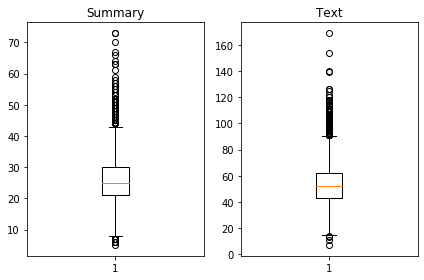

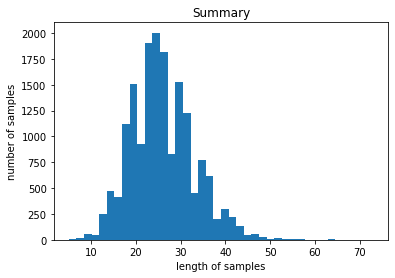

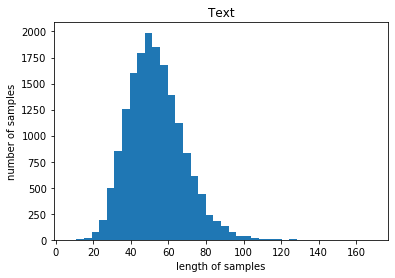

In [122]:
# 길이 분포 출력
text_len = [len(s.split()) for s in df_news['추출']]
summary_len = [len(s.split()) for s in df_news['생성']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [123]:
df_news.head()

,추출,생성
0,검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·검찰·법원 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다 이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 기관과의 상호 감시와 견제를 통해 국민의 인권을 증진하자는 것이다,정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력의 견제와 균형을 이루어 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다
1,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 ‘소나무허리노린재’가 인천지역 공원과 산림에서 확인했다 15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는 월미도와 인천대학교 송도캠퍼스 등에서 정착한 개체군을 확인했다 국내에서 발생이 확대될 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 예상된다,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 월미도와 인천대학교 송도캠퍼스 등에서 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 소나무허리노린재의 개체군이 정착한 것을 확인했으며 국내에서 발생이 늘어날 경우 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 우려된다
2,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 따른 심평원 설립 취지를 훼손시키고 있다는 지적이 대두됐다 더불어민주당 김상희 국회원이 건강보험공단에서 확인한 자료에 따르면 심평원은 2015년 이전부터 수사기관에서 의뢰가 들어오면 간간히 지원업무를 해오다 2015년 1월부터 전담부서인 공공심사부를 설치했으며 2016년 ‘보험사기방지 특별법’이 제정되면서 법에 따라 공식적으로 입원적정성 심사 업무를 수행해 왔다 문제는 돈이 건강보험 재정에서 나온다는 것이다,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험사기 방지’ 업무를 수행해 심평원이 건강보험 재정으로 민간보험사의 이익을 활성화하는 역할을 수행하고 있다고 비판했다
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 운영한다고 26일 밝혔다 가족 체험에 참여하면 포도 수확 포도 맛보기 체험을 하고 수확한 포도를 가져갈 있다 관계자는 도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소중한 추억이 것이라며 시민들이 지역의 농업과 농촌을 이해하고 농산물을 믿고 구입하는 기회가 되길 바란다고 말했다,부천시는 포도를 수확하고 맛도 있으며 수확한 포도을 가져갈 있는 포도 수확 체험 프로그램을 운영하여 시민들에게 추억을 남기고 농산물에 대한 신뢰를 높이는 기회로 삼고 있다
4,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 문화소풍’을 올해 마지막으로 추진했다 23일 가평읍에 따르면 ‘힐링 문화소풍 ’은 복지사각지대에 있는 지역 어르신들을 대상으로 6회 진행되는 사업으로 협의체 위원과 짝꿍이 되어 영화관람 협력업체인 파주닭국수 가평점에서 같이 식사를 하고 협의체위원들이 짝꿍을 모시는 특화사업이다 내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다라고 말했다,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께하는 힐링 문화소풍’을 진행했고 내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 시간을 가질 계획이라고 말했다


In [147]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
df_news['decoder_input'] = df_news['생성'].apply(lambda x : 'sostoken '+ x)
df_news['decoder_target'] = df_news['생성'].apply(lambda x : x + ' eostoken')
df_news.head()

,추출,생성,decoder_input,decoder_target
0,검경 수사권 개혁에 대한 문제는 정부의 핵심 과제이다 형사 사법제도의 본질은 경찰·검찰·법원 삼권 분립으로 상호 견제와 균형을 이뤄 대등한 관계에서 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다 이번 수사권 조정의 핵심은 검찰의 제왕적 권한을 분산해 기관과의 상호 감시와 견제를 통해 국민의 인권을 증진하자는 것이다,정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력의 견제와 균형을 이루어 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다,sostoken 정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력의 견제와 균형을 이루어 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다,정부의 핵심 과제인 검경 수사권 조정의 핵심은 검찰의 막강한 권한을 분산해 권력의 견제와 균형을 이루어 불합리한 수사구조를 개선하고 국민의 인권을 강화하는 것이다 eostoken
1,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 ‘소나무허리노린재’가 인천지역 공원과 산림에서 확인했다 15일 사업단에 따르면 외래 산림해충 모니터링과 문헌조사를 병행해 출현 기록이 있는 월미도와 인천대학교 송도캠퍼스 등에서 정착한 개체군을 확인했다 국내에서 발생이 확대될 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 예상된다,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 월미도와 인천대학교 송도캠퍼스 등에서 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 소나무허리노린재의 개체군이 정착한 것을 확인했으며 국내에서 발생이 늘어날 경우 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 우려된다,sostoken 임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 월미도와 인천대학교 송도캠퍼스 등에서 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 소나무허리노린재의 개체군이 정착한 것을 확인했으며 국내에서 발생이 늘어날 경우 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 우려된다,임업진흥원 외래 무척추동물의 확산 변화예측 기술개발 사업단이 월미도와 인천대학교 송도캠퍼스 등에서 소나무의 어린 솔방울을 집중적으로 가해하는 외래 해충인 소나무허리노린재의 개체군이 정착한 것을 확인했으며 국내에서 발생이 늘어날 경우 침엽수 비중이 높은 산림생태계 가평 등지의 생산에 심각한 피해가 우려된다 eostoken
2,건강보험 심사평가원의 ‘보험사기 방지’ 업무가 민간보험사의 배를 불리며 건보 법에 따른 심평원 설립 취지를 훼손시키고 있다는 지적이 대두됐다 더불어민주당 김상희 국회원이 건강보험공단에서 확인한 자료에 따르면 심평원은 2015년 이전부터 수사기관에서 의뢰가 들어오면 간간히 지원업무를 해오다 2015년 1월부터 전담부서인 공공심사부를 설치했으며 2016년 ‘보험사기방지 특별법’이 제정되면서 법에 따라 공식적으로 입원적정성 심사 업무를 수행해 왔다 문제는 돈이 건강보험 재정에서 나온다는 것이다,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험사기 방지’ 업무를 수행해 심평원이 건강보험 재정으로 민간보험사의 이익을 활성화하는 역할을 수행하고 있다고 비판했다,sostoken 더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험사기 방지’ 업무를 수행해 심평원이 건강보험 재정으로 민간보험사의 이익을 활성화하는 역할을 수행하고 있다고 비판했다,더불어민주당 김상희 의원은 2016년 ‘보험사기방지 특별법’이 제정됨에 따라 ‘보험사기 방지’ 업무를 수행해 심평원이 건강보험 재정으로 민간보험사의 이익을 활성화하는 역할을 수행하고 있다고 비판했다 eostoken
3,부천시는 어린이들이 지역의 포도를 직접 수확해 보는 ‘포도 수확 체험 프로그램’을 운영한다고 26일 밝혔다 가족 체험에 참여하면 포도 수확 포도 맛보기 체험을 하고 수확한 포도를 가져갈 있다 관계자는 도심에서는 평소 접하기 어려운 포도 수확 체험이 시민들에게 즐겁고 소중한 추억이 것이라며 시민들이 지역의 농업과 농촌을 이해하고 농산물을 믿고 구입하는 기회가 되길 바란다고 말했다,부천시는 포도를 수확하고 맛도 있으며 수확한 포도을 가져갈 있는 포도 수확 체험 프로그램을 운영하여 시민들에게 추억을 남기고 농산물에 대한 신뢰를 높이는 기회로 삼고 있다,sostoken 부천시는 포도를 수확하고 맛도 있으며 수확한 포도을 가져갈 있는 포도 수확 체험 프로그램을 운영하여 시민들에게 추억을 남기고 농산물에 대한 신뢰를 높이는 기회로 삼고 있다,부천시는 포도를 수확하고 맛도 있으며 수확한 포도을 가져갈 있는 포도 수확 체험 프로그램을 운영하여 시민들에게 추억을 남기고 농산물에 대한 신뢰를 높이는 기회로 삼고 있다 eostoken
4,가평군 가평읍지사협은 최근 특화사업인 문화체험 행복나들이 ‘어르신과 함께하는 힐링 문화소풍’을 올해 마지막으로 추진했다 23일 가평읍에 따르면 ‘힐링 문화소풍 ’은 복지사각지대에 있는 지역 어르신들을 대상으로 6회 진행되는 사업으로 협의체 위원과 짝꿍이 되어 영화관람 협력업체인 파주닭국수 가평점에서 같이 식사를 하고 협의체위원들이 짝꿍을 모시는 특화사업이다 내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 기회를 제공하도록 하겠다라고 말했다,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께하는 힐링 문화소풍’을 진행했고 내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 시간을 가질 계획이라고 말했다,sostoken 가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께하는 힐링 문화소풍’을 진행했고 내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 시간을 가질 계획이라고 말했다,가평군 가평읍지사협은 복지 사각지대에 있는 지역 어르신들을 대상으로 ‘어르신과 함께하는 힐링 문화소풍’을 진행했고 내년에도 가평읍 지사협위원들과 협력해 다양한 문화체험의 시간을 가질 계획이라고 말했다 eostoken


In [148]:
encoder_input = np.array(df_news['추출'])
decoder_input = np.array(df_news['decoder_input'])
decoder_target = np.array(df_news['decoder_target'])

## 데이터 분리

In [149]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 5615  1550  7714 ... 15005  6087  7855]


In [150]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [151]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 3394


In [152]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [153]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 13579
훈련 레이블의 개수 : 13579
테스트 데이터의 개수 : 3394
테스트 레이블의 개수 : 3394


## Encoding

In [154]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [155]:
src_tokenizer.word_index

{'있다': 1,
 '위해': 2,
 '밝혔다': 3,
 '있는': 4,
 '지난': 5,
 '위한': 6,
 '통해': 7,
 '이번': 8,
 '대한': 9,
 '따르면': 10,
 '것으로': 11,
 '함께': 12,
 '지역': 13,
 '등을': 14,
 '오는': 15,
 '이날': 16,
 '다양한': 17,
 '말했다': 18,
 '대상으로': 19,
 '가운데': 20,
 '최근': 21,
 '대해': 22,
 '따라': 23,
 '있도록': 24,
 '올해': 25,
 '관련': 26,
 '특히': 27,
 '오후': 28,
 '했다': 29,
 '예정이다': 30,
 '시는': 31,
 '전국': 32,
 '열린': 33,
 '지난해': 34,
 '등의': 35,
 '지원': 36,
 '하는': 37,
 '계획이다': 38,
 '이어': 39,
 '전남': 40,
 '이에': 41,
 '등에': 42,
 '국내': 43,
 '사업': 44,
 '관계자는': 45,
 '결과': 46,
 '등이': 47,
 '지난달': 48,
 '많은': 49,
 '가장': 50,
 '이상': 51,
 '‘2019': 52,
 '주제로': 53,
 '오전': 54,
 '한편': 55,
 '개최했다': 56,
 '직접': 57,
 '원을': 58,
 '주요': 59,
 '새로운': 60,
 '내년': 61,
 '따른': 62,
 '있어': 63,
 '나타났다': 64,
 '최대': 65,
 '현재': 66,
 '같은': 67,
 '한다': 68,
 '이후': 69,
 '것을': 70,
 '맞아': 71,
 '사업을': 72,
 '하고': 73,
 '광주': 74,
 '도내': 75,
 '24일': 76,
 '명이': 77,
 '열고': 78,
 '것이다': 79,
 '참석한': 80,
 '운영': 81,
 '30일': 82,
 '22일': 83,
 '통한': 84,
 '17일': 85,
 '대구': 86,
 '18일': 87,
 '28일': 88,
 '등으로'

In [ ]:
src_tokenizer = Tokenizer(num_words = len(src_tokenizer.word_index)) 
src_tokenizer.fit_on_texts(encoder_input_train)

In [192]:
src_tokenizer.word_index

{'있다': 1,
 '위해': 2,
 '밝혔다': 3,
 '있는': 4,
 '지난': 5,
 '위한': 6,
 '통해': 7,
 '이번': 8,
 '대한': 9,
 '따르면': 10,
 '것으로': 11,
 '함께': 12,
 '지역': 13,
 '등을': 14,
 '오는': 15,
 '이날': 16,
 '다양한': 17,
 '말했다': 18,
 '대상으로': 19,
 '가운데': 20,
 '최근': 21,
 '대해': 22,
 '따라': 23,
 '있도록': 24,
 '올해': 25,
 '관련': 26,
 '특히': 27,
 '오후': 28,
 '했다': 29,
 '예정이다': 30,
 '시는': 31,
 '전국': 32,
 '열린': 33,
 '지난해': 34,
 '등의': 35,
 '지원': 36,
 '하는': 37,
 '계획이다': 38,
 '이어': 39,
 '전남': 40,
 '이에': 41,
 '등에': 42,
 '국내': 43,
 '사업': 44,
 '관계자는': 45,
 '결과': 46,
 '등이': 47,
 '지난달': 48,
 '많은': 49,
 '가장': 50,
 '이상': 51,
 '‘2019': 52,
 '주제로': 53,
 '오전': 54,
 '한편': 55,
 '개최했다': 56,
 '직접': 57,
 '원을': 58,
 '주요': 59,
 '새로운': 60,
 '내년': 61,
 '따른': 62,
 '있어': 63,
 '나타났다': 64,
 '최대': 65,
 '현재': 66,
 '같은': 67,
 '한다': 68,
 '이후': 69,
 '것을': 70,
 '맞아': 71,
 '사업을': 72,
 '하고': 73,
 '광주': 74,
 '도내': 75,
 '24일': 76,
 '명이': 77,
 '열고': 78,
 '것이다': 79,
 '참석한': 80,
 '운영': 81,
 '30일': 82,
 '22일': 83,
 '통한': 84,
 '17일': 85,
 '대구': 86,
 '18일': 87,
 '28일': 88,
 '등으로'

In [191]:
len(src_tokenizer.word_index)

189384

In [156]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [157]:
print(encoder_input_train[:3])

[[2586, 775, 3845, 9992, 2, 13, 184, 9993, 36303, 315, 16953, 344, 11182, 36304, 328, 4, 20, 3260, 21, 775, 61139, 16954, 14422, 4684, 26204, 20616, 5608, 643, 1489, 1, 152, 42, 10, 31, 48, 1972, 1336, 203, 61140, 576, 61141, 278, 166, 61142, 98, 3652, 20617, 61143, 31, 644, 16954, 14422, 20618, 26204, 20616, 3117, 668, 20619, 617, 61144, 704, 1489, 1], [25, 332, 32, 1075, 4685, 1283, 61145, 34, 67, 266, 61146, 61147, 12638, 594, 1359, 61148, 36305, 26, 1337, 523, 4685, 4203, 20620, 5609, 2494, 2208, 2996, 36305, 2587, 1337, 2021, 317, 1, 1455, 650, 2022, 61149, 26205, 36306, 100, 1207, 26206, 11183, 51, 3118, 20621, 19, 6006, 36307, 11184, 36308, 36309, 61150], [3653, 5, 92, 33, 52, 1307, 16955, 26207, 149, 1973, 6453, 1308, 630, 8224, 1681, 1307, 749, 6932, 26208, 105, 3, 258, 3119, 8225, 61151, 977, 20622, 358, 196, 1919, 227, 2088, 3120, 51, 36310, 36311, 19, 36312, 1181, 2888, 4031, 5610, 61152, 61153, 232, 61154, 61155, 61156, 61157, 61158, 762, 139, 4686, 61159, 352, 630, 26209,

In [158]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [159]:
tar_tokenizer = Tokenizer(num_words = len(tar_tokenizer.word_index)) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [160]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [161]:
print(decoder_input_train[:5])

[[1, 2028, 2556, 409, 4985, 33214, 19737, 3730, 33215, 19738, 588, 480, 400, 5], [1, 4986, 501, 33216, 2029, 1016, 7516, 24, 328, 890, 4060, 949, 14023, 33217, 5610, 1655, 33218, 14024, 33219, 33220], [1, 1157, 96, 794, 26, 1198, 14025, 7517, 33221, 151, 117, 187, 33222, 19739, 13, 401, 33223, 35, 1017, 1198, 94, 33224, 1571, 33225, 4987, 4], [1, 1931, 33226, 33227, 9, 19740, 33228, 502, 8, 1572, 14026, 649, 33229, 656, 6449, 33230, 237, 14027, 392, 33231, 2400, 2753, 19741, 7518, 14026, 2557, 4061, 105, 82, 4], [1, 26, 14028, 19742, 2558, 101, 19743, 699, 1018, 33232, 795, 20, 14029, 6450, 4482, 19744, 4482, 19745, 3731, 33233, 437, 752, 33234, 33235, 4988, 19746, 189, 3427, 33236, 4482, 5611, 1500, 10, 33237, 189, 3427, 5612, 11, 204]]


In [162]:
print(decoder_target_train[:5])

[[2028, 2556, 409, 4985, 33214, 19737, 3730, 33215, 19738, 588, 480, 400, 5, 2], [4986, 501, 33216, 2029, 1016, 7516, 24, 328, 890, 4060, 949, 14023, 33217, 5610, 1655, 33218, 14024, 33219, 33220, 2], [1157, 96, 794, 26, 1198, 14025, 7517, 33221, 151, 117, 187, 33222, 19739, 13, 401, 33223, 35, 1017, 1198, 94, 33224, 1571, 33225, 4987, 4, 2], [1931, 33226, 33227, 9, 19740, 33228, 502, 8, 1572, 14026, 649, 33229, 656, 6449, 33230, 237, 14027, 392, 33231, 2400, 2753, 19741, 7518, 14026, 2557, 4061, 105, 82, 4, 2], [26, 14028, 19742, 2558, 101, 19743, 699, 1018, 33232, 795, 20, 14029, 6450, 4482, 19744, 4482, 19745, 3731, 33233, 437, 752, 33234, 33235, 4988, 19746, 189, 3427, 33236, 4482, 5611, 1500, 10, 33237, 189, 3427, 5612, 11, 204, 2]]


## 빈 샘플 제거

In [163]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [164]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [165]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 13579
훈련 레이블의 개수 : 13579
테스트 데이터의 개수 : 3394
테스트 레이블의 개수 : 3394


## Padding

In [167]:
text_max_len = 169
summary_max_len = 73

In [168]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## Seq2Seq + Attention Summary Model

In [169]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [173]:
src_vocab= len(src_tokenizer.word_index)
tar_vocab= len(tar_tokenizer.word_index)

In [174]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [175]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [176]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 169)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 169, 128)     24241152    input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 169, 256), ( 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [177]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [178]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 169)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 169, 128)     24241152    input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 169, 256), ( 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [179]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [180]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 10, callbacks=[es]
                    , epochs = 32)

Epoch 1/32
1358/1358 [==============================] - 3465s 3s/step - loss: 3.7521 - val_loss: 2.6494
Epoch 2/32
1358/1358 [==============================] - 3470s 3s/step - loss: 3.6019 - val_loss: 2.6516
Epoch 3/32
1358/1358 [==============================] - 3444s 3s/step - loss: 3.5513 - val_loss: 2.6195
Epoch 4/32
1358/1358 [==============================] - 3435s 3s/step - loss: 3.5118 - val_loss: 2.5955
Epoch 5/32
1358/1358 [==============================] - 3434s 3s/step - loss: 3.4798 - val_loss: 2.5787
Epoch 6/32
1358/1358 [==============================] - 3435s 3s/step - loss: 3.4582 - val_loss: 2.5684
Epoch 7/32
1358/1358 [==============================] - 3423s 3s/step - loss: 3.4417 - val_loss: 2.5601
Epoch 8/32
1358/1358 [==============================] - 3431s 3s/step - loss: 3.4406 - val_loss: 2.5475
Epoch 9/32
1358/1358 [==============================] - 3434s 3s/step - loss: 3.4687 - val_loss: 2.5556
Epoch 10/32
1358/1358 [==============================] - 3433s 3

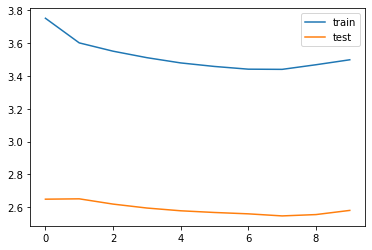

In [181]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 평가

In [182]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [183]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [184]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [185]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [186]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [187]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [188]:
for i in range(5, 20):
    print("추출문 : ",seq2text(encoder_input_test[i]))
    print("요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

추출문 :  평택시는 공교육 강화 미래 인재 육성을 위해 ‘2020년 교육경비 지원사업’을 적극적으로 추진한다고 4일 밝혔다 시의 교육경비 보조금 예산은 2016년부터 매년 증가해 2016년 대비 58 2 증가한 원을 편성할 예정이다 사업의 적정성 시급성 학교 형평성 등을 고려하는 한편 학부모들의 교육비 부담 경감 쾌적한 학교 시설환경 개선과 공교육 경쟁력 강화를 위한 두고 지원 대상을 결정했다 
요약문 : 평택시는 2020년 교육경비 지원사업에 원을 편성하여 적극 추진하며 지원대상은 사업의 적정성 고려하여 결정한다고 전했다 
예측 요약문 :  지난 19일 시청 대회의실에서 열린 2019년 하반기 주요 주요 지역 주요 지역 지역 지역 활성화를 위한 지역 지역 활성화를 위한 지역 지역 지역 활성화를 위한 지역 지역 지역 활성화를 위한 것으로 나타났다


추출문 :  스승의 날을 앞두고 고교생들이 ‘스승의 날’에 대해 생각을 가지고 있는지 알아보기 위해 고1 3학년 회원 대상으로 설문조사를 실시했다 이는 학생들이 단순히 공부를 가르치는 학생들에게 관심을 갖고 그들의 입장을 의견을 존중하는 것을 보여준다 현재 학교에 있는지에 대한 질문에 83 5 의 학생들이 ‘그렇다’고 답했으며 중에서도 성적에 영향을 미친다고 생각하는 학생은 71 로 매우 높게 나타났다 
요약문 : 고등학생 대상으로 스승의 설문조사를 실시하여 가르치는 학생들의 의견을 존중하는 선생님을 선호한다는 결과가 나왔으며 선생님을 것이 성적에 영향을 77 의 학생이 
예측 요약문 :  24일 경기도는 24일 열린 2019 경기도 대한 의견을 전남도는 중인 가운데 지난 19일 시청 대회의실에서 열린 가운데 경기도가 대한 의견을 전남도는 중인 있는 가운데 지난 19일 시청 대회의실에서 열린 열린 가운데 경기도가 대한 의견을 위한 의견을 밝혔다


추출문 :  질병관리본부는 지난달까지 확인된 a형간염 대해 시행한 결과 80 7 에 해당하는 섭취가 확인됐다고 11일 밝혔다 이에 a형간염 안전성 확인 시까지 섭취를 